# Выращиваем решающее дерево своими руками

### AI Masters, Машинное обучение 2

В этом ноутбуке вам предлагается реализовать решающее дерево.

## Введение

Для начала импортируем библиотеки, которые нам понадобятся в дальнейшем:

### Решающее дерево

Вспомним, что такое решающее дерево.

Решающее дерево - алгоритм машинного обучения, задающийся специальным графом-деревом. В данном задании мы будем использовать бинарное дерево. Каждая внутренняя вершина такого дерева соответствует функции предикату $\mathbb{I}[x_{\alpha} \geq \beta]$. Каждая листовая вершина соответствует некоторому значению ответа, которое будет выдавать алгоритм (вещественное число в случае регрессии, номер класса или вектор вероятностей в случае классификации).

На этапе обучения нам необходимо построить само дерево, а также выбрать $\alpha$ и $\beta$ для каждой внутренней вершины и метку прогноза для каждой листовой вершины. Задача построения "наилучшего" дерева (например того, которое не совершает ошибок и имеет минимальное число вершин) является NP-полной, поэтому при построении деревьев на практике приходиться использовать жадные алгоритмы.

На этапе применения все объекты пропускаются через дерево. Изначально, для каждого объекта вычисляется значение функции-предиката корневой вершины. Если оно равно нулю, то алгоритм переходит в левую дочернюю вершину, иначе в правую. Затем вычисляется значение предиката в новой вершине и делается переход или влево, или вправо. Процесс продолжается, пока не будет достигнута листовая вершина. Алгоритм возвращает то значение, которое будет приписано этой вершине.

### Выбор $\alpha$ и $\beta$

На этапе построения дерева мы будем выбирать предикаты для каждой новой вершины, максимизируя функционал качества для разбиения вершины на два поддерева, который можно записать в следующем виде:
$$ Q(R, \alpha, \beta) = H(R) - \frac{|R_l|}{|R|} H(R_l) - \frac{|R_r|}{|R|} H(R_r) $$

* $H$ - критерий информативности
* $R$ - объекты в текущей вершине
* $R_r$ - объекты, попадающие в правое поддерево
* $R_l$ - объекты, попадающие в левое поддерево

Например, критерий информативности Джини для задачи классификации:

$$ H(R) = 1 - \sum_{k=1}^K p_k^2 $$

* $p_k$ - доля объектов с классом $k$ среди $R$
* $K$ - общее число классов

При разбиении вершины на два поддерева мы хотим максимизировать функционал качества, оптимизируя:

* $\alpha$ - номер признака в предикате
* $\beta$ - пороговое значение предиката

В данном задании оптимизацию мы будем проводить, используя полный перебор значений. Для $\alpha$ множество перебираемых значений - все имеющиеся признаки, для $\beta$ - все встречающиеся в обучающей выборке значения каждого признака, кроме наименьшего и наибольшего.

## Визуализация результатов

Давайте проверим, что дерево работает на нескольких модельных задачах.

In [ ]:
!pip install scikit-learn matplotlib

In [13]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import sys
#sys.path.extend(['/Users/alkrasnov/Documents/AM_ML_2_25'])


from decision_tree import ClassificationDecisionTree
#%load_ext autoreload
#%autoreload 2

Функция для визуализации двумерной выборки:

In [14]:
def plot_data(X, y, figsize=(6, 5)):
    plt.figure(figsize=figsize)
    
    n_classes = y.max() + 1
    for i in range(n_classes):
        plt.plot(X[:, 0][y == i], X[:, 1][y == i], 'o')

Функция для визуализации работы дерева на двумерной выборке:

In [15]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(6, 5)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

Для начала рассмотрим простую задачу с полностью разделимыми по некоторому признаку классами:

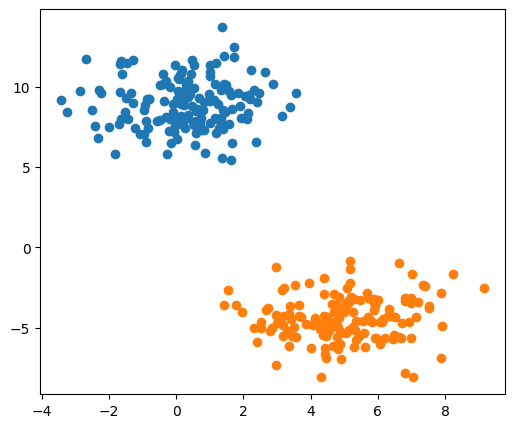

In [16]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)

plot_data(X, y)

Применим к этой задаче алгоритм "решающий пень":

In [17]:
cls_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
cls_tree.fit(X, y)

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Если вы всё реализовали правильно, то должно получиться что-то такое:

Accuracy = 1.0


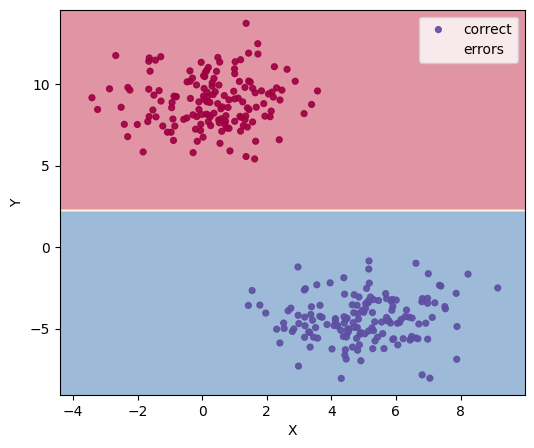

In [18]:
plot_decision_surface(cls_tree, X, y)

Теперь рассмотрим более сложную задачу с плохо разделимыми классами:

In [19]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)

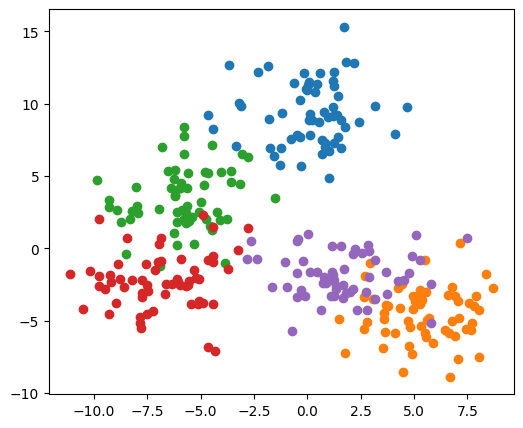

In [20]:
plot_data(X, y)

Посмотрим на результаты, которые получаются при разных значениях глубины:

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.4


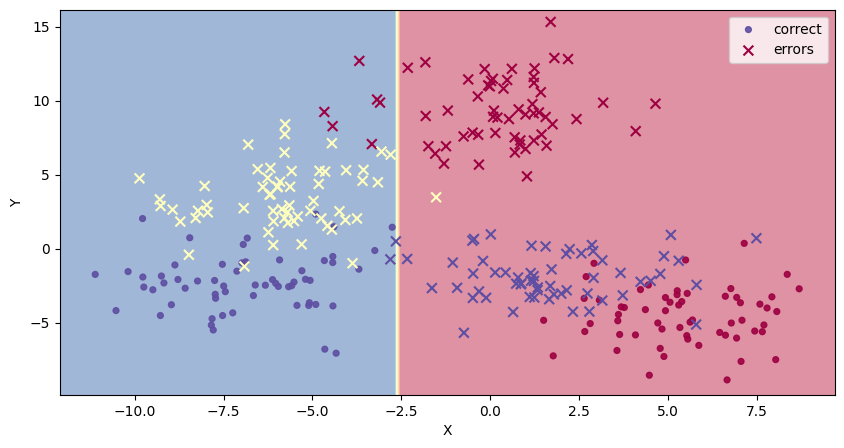

In [21]:
some_tree = ClassificationDecisionTree(max_depth=1, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.7466666666666667


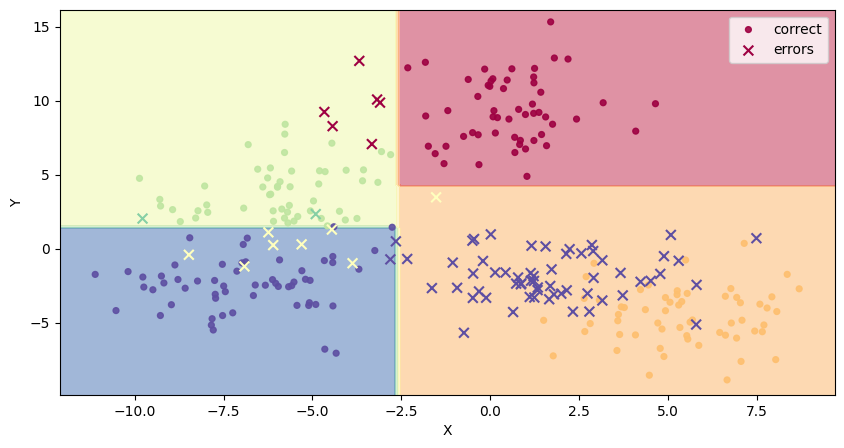

In [22]:
some_tree = ClassificationDecisionTree(max_depth=2, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.89


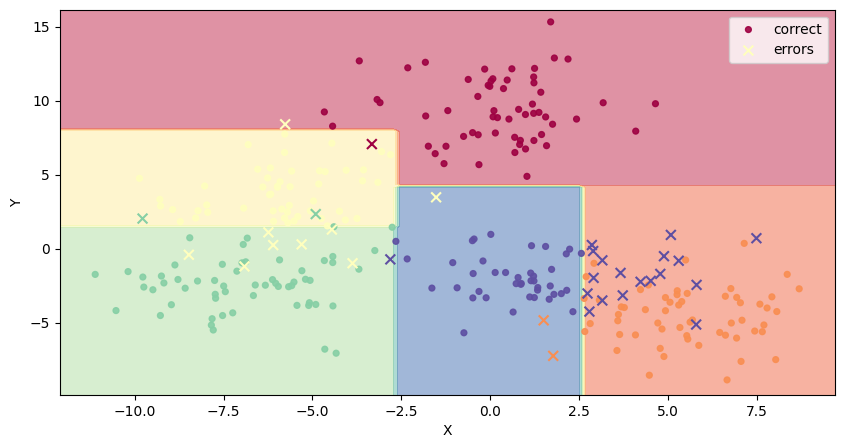

In [23]:
some_tree = ClassificationDecisionTree(max_depth=3, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.94


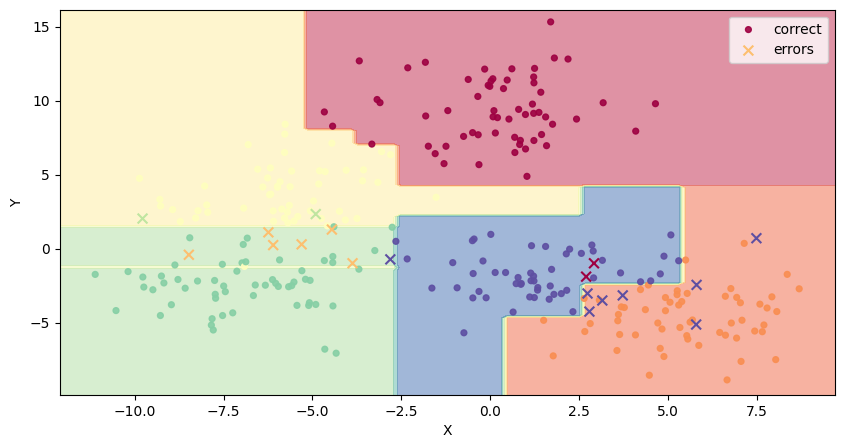

In [24]:
some_tree = ClassificationDecisionTree(max_depth=5, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 1.0


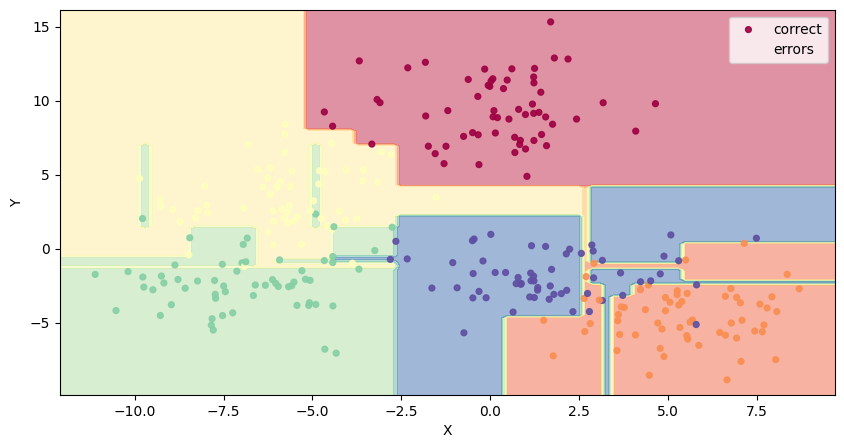

In [25]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

Можно заметить, что начиная с некоторого значения глубины, дерево начинает сильно переобучаться (новые сплиты пытаются описать максимум 1-2 объекта). Это можно поправить, изменяя параметр `min_leaf_size` или `min_improvement`.

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.95


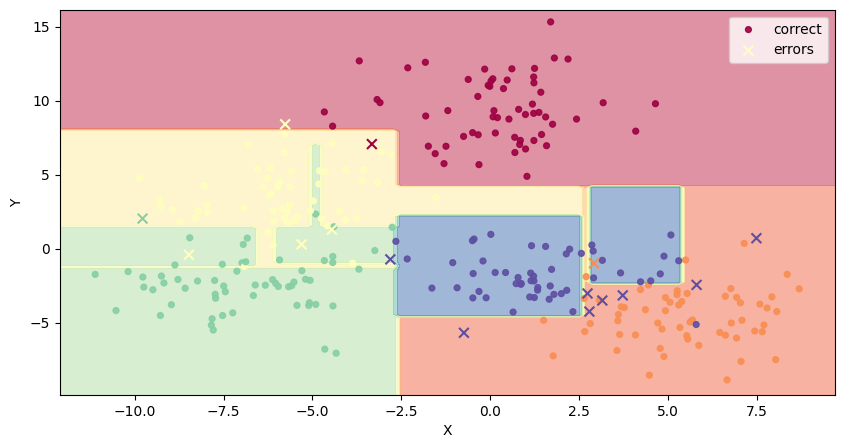

In [26]:
some_tree = ClassificationDecisionTree(max_depth=10, min_leaf_size=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.9866666666666667


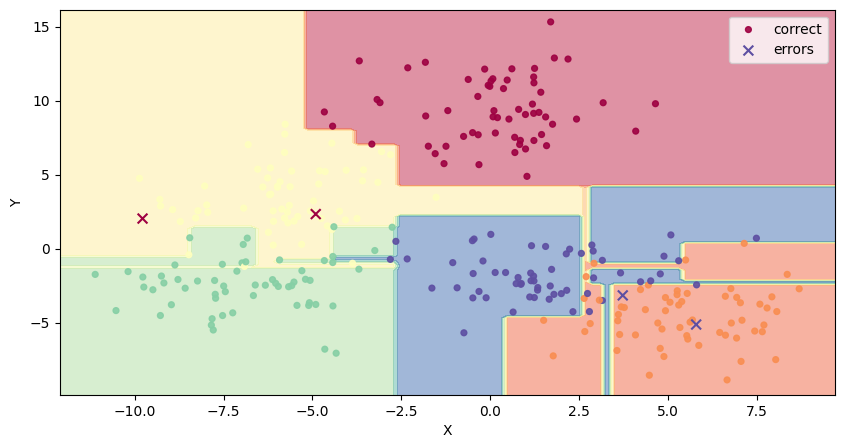

In [27]:
some_tree = ClassificationDecisionTree(max_depth=10, min_improvement=0.01, min_leaf_size=1)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))

c:\Users\Лиана\OneDrive\Desktop\MSU\Machine-learning-1\homeworks\sem2\hw1\decision_tree\criterio.py:71: RuntimeWarning: invalid value encountered in divide
  return np.bincount(target, minlength=self.n_classes) / target.shape[0]


Accuracy = 0.97


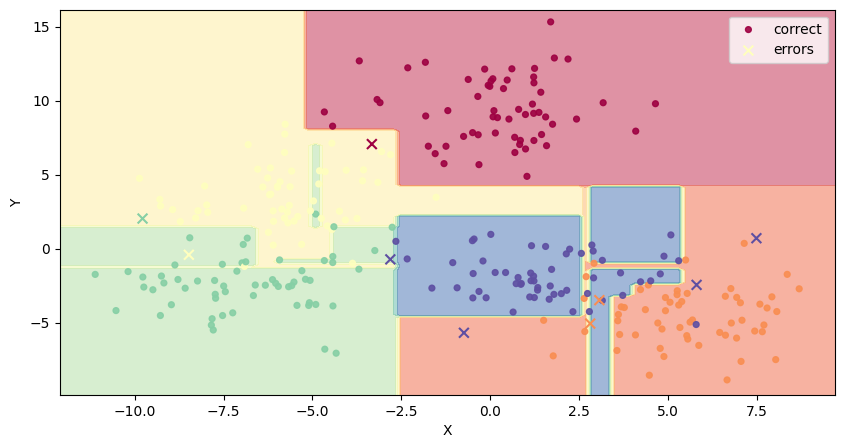

In [28]:
some_tree = ClassificationDecisionTree(max_depth=10)
some_tree.fit(X, y)

plot_decision_surface(some_tree, X, y, figsize=(10, 5))